# Projeção de Mortalidade para Projeção Populacional da Região Metropolitana de Curitiba

Este documento apresenta os procedimentos realizados para obtenção, tratamento, análise e projeção dos dados de mortalidade na Região Metropolitana de Curitiba. O resultado do modelo serão utilizados para projeção da população da região pelo método de coortes, e será utilizado para os diagnósticos e prognósticos que compõem parte do processo de elaboração do seu Plano de Desenvolvimento Integrado.

O documento traz detalhamento das rotinas computacionais em linguagem Python utilizada, para garantir reproducibilidade e verificação do rigor técnico por parte de quaisquer interessados.

## Preparação do _Notebook_

Esse documento, por ser construído em Linguagem Python, apresenta textos e código, por essa razão, sua preparação depende de importação das bibliotecas que serão utilizadas nos procedimentos analíticos.

In [1]:
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração

## Carregamento e Tratamento Dados de Óbitos
Os dados de óbitos foram obtidos a partir do [Sistema de Informações sobre Mortalidade](http://sim.saude.gov.br/), do Ministério da Saúde. O arquivo csv original passou por poucos tratamentos, contando apenas com retirada de metadados, informações de cabeçalho e registros com traços "-" alterados para 0. 
Adiante os dados são importados, com a retirada das linhas que sumarizam totais e alteração de termos mulheres e homens, para masculino e feminino.
Para conferência dos dados, as primeiras cinco linhas da tabela são exibidas

In [2]:
df_obitos = pd.read_csv('./source/tab/originais/mortalidade segundo sexo e faixa etária.csv', sep=';') #carregamento dos dados
df_obitos = df_obitos[~(df_obitos['Faixa Etária'] == 'Total')] # remoção das linhas com total
df_obitos.replace(to_replace={'Mulheres':'Feminino', 'Homens':'Masculino'}, inplace=True) # alteração de registros de mulheres e homens, para Feminino e Masculino
df_obitos.iloc[np.r_[0:2, -2:0]] #visualização das duas primeiras e das duas últimas linhas do DataFrame

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Feminino,Menor 1 ano,512,425,493,449,460,400,365,326,...,239,236,219,221,220,206,181,187,147,139
1,Feminino,1 a 4 anos,88,99,104,62,66,75,58,75,...,38,34,35,33,37,31,26,35,17,19
25,Masculino,80 anos e mais,901,944,1023,993,1070,1099,1149,1285,...,1805,1838,1963,1981,2240,2268,2327,2434,2827,3386
26,Masculino,Idade ignorada,91,60,129,85,40,3,14,51,...,6,5,7,8,2,7,7,3,5,15


### Tratamento de dados de óbitos com idade ignorada

A coluna "Faixa Etária" contava com marção de "Idade ignorada", para os casos em que os óbito não apresentaram registro de idade. Esses dados foram distribuídos por faixas etárias, conforme a proporção de óbitos com idade identificada. Em seguida, foram removidas as linhas com registro de "Idade Ignorada".  

In [3]:
for ano in df_obitos.columns[2:]:
    for sexo in df_obitos.Sexo.unique():

        #obtendo número de mortes com idade ignorada para determinado sexo em determinado ano
        obitos_idade_ignorada = df_obitos[
            (df_obitos.Sexo == sexo) 
            & (df_obitos['Faixa Etária'] =='Idade ignorada')][ano].to_numpy()

       #obtendo número de mortes com idade ignorada para determinado sexo em determinado ano 
        obitos_por_faixa_etaria = df_obitos[
            (df_obitos.Sexo == sexo) 
            & (df_obitos['Faixa Etária'] != 'Idade ignorada')
            ][ano].sum()
        
        # ponderando o número de óbitos sem marca de idade conforme a proporção de óbitos de cada faixa etária
        obitos_sem_idade_redistribuidos = (
            df_obitos[
                (df_obitos.Sexo == sexo) 
                & (df_obitos['Faixa Etária'] != 'Idade ignorada')
                ][ano].to_numpy() * 1/obitos_por_faixa_etaria * obitos_idade_ignorada
            ).round().astype(int)
        
        # somando o número ponderado de óbitos sem marcação de idade ao número original de óbitos por faixa etária 
        dados_obitos_tratados = (
            df_obitos[
                (df_obitos.Sexo == sexo) 
                & (df_obitos['Faixa Etária'] != 'Idade ignorada')
                ][ano] + obitos_sem_idade_redistribuidos).to_numpy()
        
        # Atribuindo os novos dados ao DataFrame df_obitos
        df_obitos.loc[((df_obitos.Sexo == sexo) & (df_obitos['Faixa Etária'] != 'Idade ignorada')), ano]  = dados_obitos_tratados  #

# Retirando as linhas com idade ignorada
df_obitos = df_obitos.loc[df_obitos['Faixa Etária'] != 'Idade ignorada',:]

# Atribuindo Sexo e Faixa Etária a índices do DataFrame e alterando os nomes das colunas para formato integer.
df_obitos.set_index(['Sexo', 'Faixa Etária'],inplace=True)
df_obitos.columns = [int(column) for column in df_obitos.columns]

# apresentando dois primeiros e dois últimos registros para conferência
df_obitos.iloc[np.r_[0:2, -2:0]]

1996  1997  1998  1999  2000  2001  2002  2003  \
Sexo      Faixa Etária                                                     
Feminino  Menor 1 ano      514   426   495   450   461   400   365   326   
          1 a 4 anos        88    99   104    62    66    75    58    75   
Masculino 70 a 79 anos    1513  1442  1632  1599  1702  1643  1717  1874   
          80 anos e mais   910   950  1038  1002  1075  1099  1151  1292   

                          2004  2005  ...  2012  2013  2014  2015  2016  2017  \
Sexo      Faixa Etária                ...                                       
Feminino  Menor 1 ano      302   290  ...   239   236   219   221   220   206   
          1 a 4 anos        46    67  ...    38    34    35    33    37    31   
Masculino 70 a 79 anos    1837  1746  ...  1944  2115  2029  2130  2297  2107   
          80 anos e mais  1382  1339  ...  1806  1839  1964  1982  2240  2269   

                          2018  2019  2020  2021  
Sexo      Faixa Etária                            
Feminino  Menor 1 ano      181   187   147   139  
          1 a 4 anos        26    35    17    19  
Masculino 70 a 79 anos    2266  2383  3017  3858  
          80 anos e mais  2328  2435  2828  3389  

[4 rows x 26 columns]

## Carregamento e Tratamento de Dados de População - 1996 a 2022

### Dados Originais

Os dados de população foram obtidos da Contagem da População de 1996, bem como dos Censos Demográficos 2000, 2010, 2022, a partir do [Sistema IBGE de Recuperação de Dados - SIDRA](https://sidra.ibge.gov.br/).
No momento da elaboração deste estudo, o Instituto Brasileiro de Geografia e Estatística - IBGE -, havia divulgado apenas o total de população por municípios, sem marcação de sexo ou faixas etárias. Por essa razão, em caráter preliminar, até a divulgação dessas informações, foi feita a distribuição da população por sexo e faixas etárias conforme a [projeção populacional do Ipardes](https://www.ipardes.pr.gov.br/Pagina/Projecao-da-Populacao-dos-Municipios-do-Parana-2018-2040) para 2022 para os municípios da RMC. Dessa forma, garantiu-se o número total de população conforme o levantamento censitário, mas uma distribuição razoável da população por coortes de sexo e faixa etária, conforme um estudo de metodologia robusta, aplicado por aquele instituto paranaense de pesquisa.

In [4]:
# Carregamento dos dados do arquivo "pop 1996 a 2022.csv" para o DataFrame df_pop_1996_2022
df_pop_1996_2022 = pd.read_csv('./source/tab/originais/pop 1996 a 2022.csv'
                               ,sep=';'
                               , usecols=['Faixa Etária', 'Sexo', '1996', '2000', '2010', '2022']
                               )

#atribuição de tipo integer para os nomes das colunas, para compatibilização com dataframe de mortalidade
df_pop_1996_2022.columns = ['Faixa Etária', 'Sexo', 1996, 2000, 2010, 2022]

# alteração de registros de mulheres e homens, para Feminino e Masculino
df_pop_1996_2022.replace(to_replace={'Mulheres':'Feminino', 'Homens':'Masculino'}, inplace=True)

df_pop_1996_2022.set_index(['Sexo','Faixa Etária'], inplace=True)

#observação preliminar dos dados
df_pop_1996_2022.iloc[np.r_[0:2, -2:0]]

1996    2000   2010   2022
Sexo      Faixa Etária                               
Feminino  Menor 1 ano     24127   25789  21664  18157
          1 a 4 anos      94310  102495  88000  80782
Masculino 70 a 79 anos    21126   26761  38374  69260
          80 anos e mais   5975    7556  13456  24792

### Cálculo de Taxa de Crescimento e Estimativa de População em Períodos Intercensitários

Com base nos dados populacionais de 1996, 2000, 2010 e 2022, foram calculadas as taxas geométricas de crescimento intercensitário para se calcular a população em cada ano desses intervalos. Optou-se por essa abordagem, pois as estimativas anuais do IBGE, com a principal finalidade de subsidir a distribuição do Fundo de Participação dos Muncípios não são revistas após a publicação dos resultados do Censo subsquente. Por essa razão, acredita-se que a abordagem ora adotada tenha vantagens para dar base ao cálculo ao posterior cálculo de mortalidade por 1.000 habitantes.


In [5]:
# Criação do DataFrame df_taxa_crecimento_pop
df_taxa_crecimento_pop = pd.DataFrame()

# Cálculo de taxa de crescimento geométrico anual para cada período intercensitário
df_taxa_crecimento_pop['1996 a 2000'] = (df_pop_1996_2022[2000] / df_pop_1996_2022[1996])**(1/(2000-1996)) - 1
df_taxa_crecimento_pop['2000 a 2010'] = (df_pop_1996_2022[2010] / df_pop_1996_2022[2000])**(1/(2010-2000)) - 1
df_taxa_crecimento_pop['2010 a 2022'] = (df_pop_1996_2022[2022] / df_pop_1996_2022[2010])**(1/(2022-2010)) - 1


# Iteração a partir das taxas de crescimento e estimativa da população para cada faixa etária e sexo por ano intercensitário
for taxa in df_taxa_crecimento_pop.columns:
    ano_inicial, ano_final = [int(ano.strip()) for ano in taxa.split('a')]    
    for ano in range(ano_inicial, ano_final):
        #inserção dos dados calculados em novas colunas do DataFrame df_pop_1996_2022
        df_pop_1996_2022[ano] = (df_pop_1996_2022[ano_inicial]*((1+ df_taxa_crecimento_pop[taxa])**(ano-ano_inicial))).astype(int)


# reorganização da ordem das colunas, de 1996 a 2022 no DataFrame
df_pop_1996_2022 = df_pop_1996_2022[range(df_pop_1996_2022.columns.min(), df_pop_1996_2022.columns.max()+1)]

# salvamento de resultados preliminares
df_pop_1996_2022.to_csv('./source/tab/results/pop_1996_2022_estimativa_intercensitaria.csv', sep=';', encoding='utf-8')

#observação preliminar dos dados
df_pop_1996_2022.iloc[np.r_[0:2, -2:0]]

1996   1997   1998    1999    2000    2001   2002  \
Sexo      Faixa Etária                                                         
Feminino  Menor 1 ano     24127  24532  24944   25363   25789   25343  24905   
          1 a 4 anos      94310  96292  98317  100384  102495  100944  99416   
Masculino 70 a 79 anos    21126  22412  23777   25224   26761   27743  28761   
          80 anos e mais   5975   6336   6719    7125    7556    8004   8480   

                           2003   2004   2005  ...   2013   2014   2015  \
Sexo      Faixa Etária                         ...                        
Feminino  Menor 1 ano     24475  24052  23636  ...  20728  20425  20127   
          1 a 4 anos      97912  96430  94971  ...  86137  85525  84917   
Masculino 70 a 79 anos    29816  30911  32045  ...  44478  46721  49078   
          80 anos e mais   8984   9517  10083  ...  15677  16496  17357   

                           2016   2017   2018   2019   2020   2021   2022  
Sexo      Faixa Etária                                                     
Feminino  Menor 1 ano     19833  19543  19257  18976  18699  18426  18157  
          1 a 4 anos      84313  83714  83119  82529  81942  81360  80782  
Masculino 70 a 79 anos    51553  54153  56885  59754  62768  65934  69260  
          80 anos e mais  18264  19218  20223  21279  22391  23561  24792  

[4 rows x 27 columns]

## Cálculo de Taxa de Mortalidade

Com base nos dados populacionais, "df_pop_1996_2022", e de óbitos, "df_obitos", calculou-se os dados mortalidade por 1.000 habitantes, que foram atribuídos ao DataFrame df_mortalidade.

In [6]:
# Cálculo de taxas de mortalidade e atribuição ao DataFrame df_mortalidade
df_mortalidade = (df_obitos / df_pop_1996_2022.iloc[:,:-1] * 1000).round(2)

#observação preliminar dos dados
df_mortalidade.iloc[np.r_[0:2, -2:0]]

1996    1997    1998    1999    2000    2001  \
Sexo      Faixa Etária                                                     
Feminino  Menor 1 ano      21.30   17.37   19.84   17.74   17.88   15.78   
          1 a 4 anos        0.93    1.03    1.06    0.62    0.64    0.74   
Masculino 70 a 79 anos     71.62   64.34   68.64   63.39   63.60   59.22   
          80 anos e mais  152.30  149.94  154.49  140.63  142.27  137.31   

                            2002    2003    2004    2005  ...    2012    2013  \
Sexo      Faixa Etária                                    ...                   
Feminino  Menor 1 ano      14.66   13.32   12.56   12.27  ...   11.36   11.39   
          1 a 4 anos        0.58    0.77    0.48    0.71  ...    0.44    0.39   
Masculino 70 a 79 anos     59.70   62.85   59.43   54.49  ...   45.91   47.55   
          80 anos e mais  135.73  143.81  145.21  132.80  ...  121.22  117.31   

                            2014    2015    2016    2017    2018    2019  \
Sexo      Faixa Etária                                                     
Feminino  Menor 1 ano      10.72   10.98   11.09   10.54    9.40    9.85   
          1 a 4 anos        0.41    0.39    0.44    0.37    0.31    0.42   
Masculino 70 a 79 anos     43.43   43.40   44.56   38.91   39.83   39.88   
          80 anos e mais  119.06  114.19  122.65  118.07  115.12  114.43   

                            2020    2021  
Sexo      Faixa Etária                    
Feminino  Menor 1 ano       7.86    7.54  
          1 a 4 anos        0.21    0.23  
Masculino 70 a 79 anos     48.07   58.51  
          80 anos e mais  126.30  143.84  

[4 rows x 26 columns]

## Análise Exploratória de Dados de Mortalidade da RMC

Para tomada de decisão sobre a mais adequada abordagem para projeção da taxa de mortalidade, componente fundamental para a projeção populacional da RMC pelo método de coortes, foi realizada uma breve análise exploratória do padrão de ascendente ou descendente da taxa de mortalidade entre os anos de 1996 e 2021, conforme faixas etárias.
Observa-se no Gráfico 1 adiante que a mortalidade tem uma tendência de queda para todas as faixas etárias, especialmente para aquelas com maior prevalência de óbitos por 1.000 habitantes. No entanto, nos anos de 2020 e de 2021, houve uma grande inflexão na curva, possivelmente por conta da Pandemia de SARS-CoV-2, causado pelo Coronovirus - Covid-19.
Diante desse quadro, entendeu-se como adequado que as projeções fossem realizadas com corte final em 2019, que é o último ano em que as taxas de mortalidade sob condições sanitárias não emergenciais foram observadas na série.

In [7]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum().iloc[np.r_[0:2, -2:0]]

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
1 a 4 anos,1.93,2.05,2.05,1.51,1.57,1.57,1.28,1.47,1.27,1.28,...,0.96,0.92,0.76,0.76,0.92,0.80,0.88,0.95,0.51,0.57
10 a 14 anos,1.17,0.82,0.77,0.74,0.73,0.70,0.79,0.68,0.62,0.72,...,0.62,0.71,0.52,0.44,0.46,0.39,0.40,0.36,0.40,0.44
80 anos e mais,285.05,276.47,272.98,252.22,251.61,242.75,241.68,251.03,252.79,225.29,...,215.39,215.96,214.68,208.82,221.67,211.62,210.04,206.48,222.66,254.71
Menor 1 ano,50.44,42.38,44.98,39.01,38.03,34.27,31.63,29.95,26.89,26.41,...,25.20,23.42,23.86,24.71,23.46,22.41,21.96,20.36,18.16,17.88


Text(0.5, 1.0, 'Gráfico 1- Mortalidade por faixa etária (2006 a 2021)')

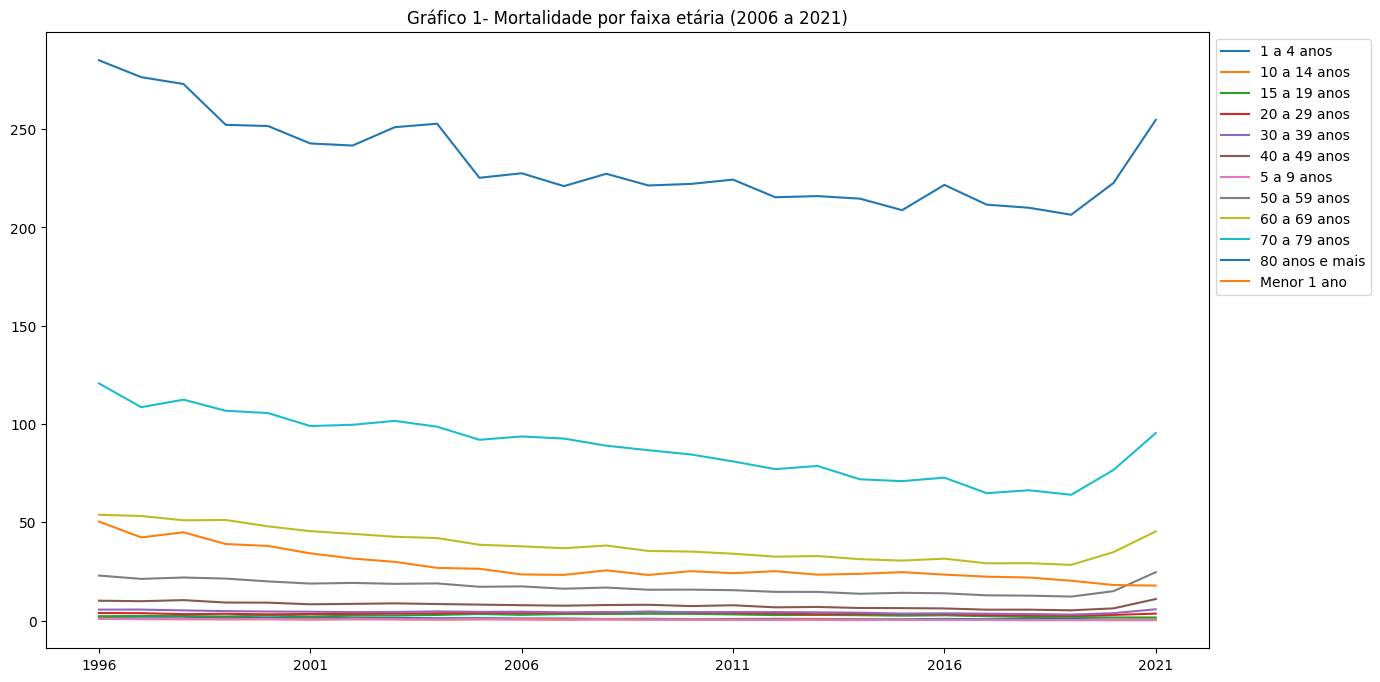

In [8]:
df_mortalidade.reset_index().set_index(['Sexo']).groupby(['Faixa Etária']).sum().transpose().plot(kind='line', figsize=(15,8))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Gráfico 1- Mortalidade por faixa etária (2006 a 2021)')

## Modelagem da Variação Anual dos Dados de Mortalidade

Após testes prévios com modelos lineares, que apresentaram casos de projeção futura de mortalidade negativa, optou-se por criar um modelo exponencial. Vários testes foram realizados com diferentes fórmulas baseadas na base neperiana (número de Euler) elevada a valores negativos e fracionários de mortalidade. Até que se chegou à fórmula adiante

$$
mortalidade = f(ano) = \text{constante} \cdot e^{\text{coeficiente} \cdot (-ano - 1)}
$$

A curva, com seus parâmetros, constante e coeficiente, foi ajustada aos dados com base no biblioteca SciPy - Scientific Python<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Essa biblioteca ajusta os parâmetros método de Mínimos Quadrados Não Lineares. Esse é um processo que busca a otimização do quadrado dos resíduos (quadrado da diferença entre valores preditos pelo modelo e valores reais). Nesse processo é utilizado o método de Levenberg-Marquardt, que é o mais comumente utilizado em procedimentos para os quais não se apresente restrições aos valores a serem testados iterativamente como parâmetros<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).


<a name="cite_note-1"></a>1. [^](#cite_ref-1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

<a name="cite_note-2"></a>2. [^](#cite_ref-2) https://sites.cs.ucsb.edu/~yfwang/courses/cs290i_mvg/pdf/LMA.pdf


/tmp/ipykernel_349/639620179.py:3: RuntimeWarning: overflow encountered in exp
  return constante * np.exp(coeficiente * (-x - 1));
/tmp/ipykernel_349/639620179.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, df_temp], ignore_index=True)


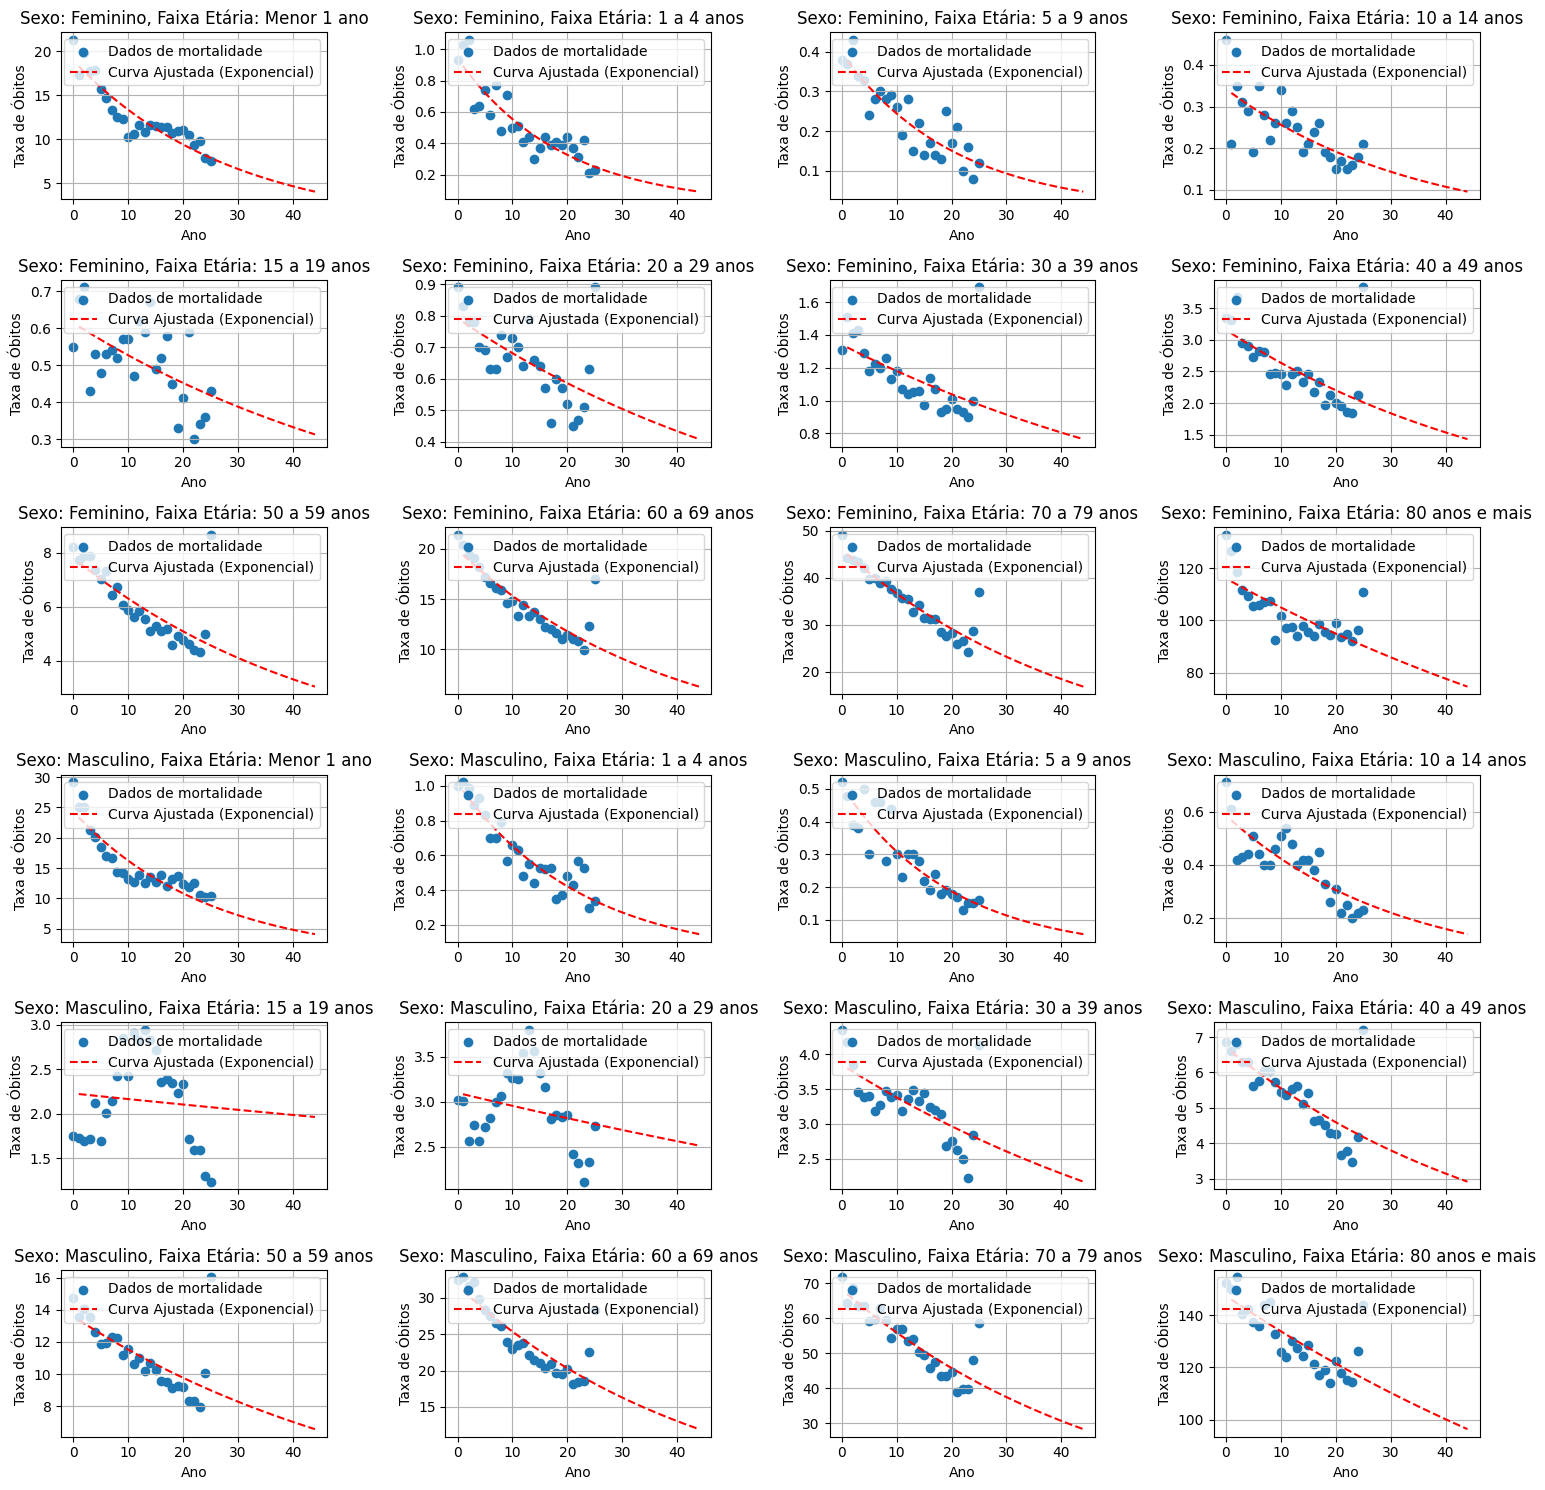

In [9]:
# Função para o modelo exponencial decrescente
def modelo_exponencial(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1));

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Sexo', 'Faixa Etária', 'Constante', 'Coeficiente'])

# Combinações de sexo e faixa etária
df_mortalidade.reset_index(inplace=True)
sexos = df_mortalidade['Sexo'].unique()
faixas_etarias = df_mortalidade['Faixa Etária'].unique()
num_plots = len(sexos) * len(faixas_etarias)
num_colunas = 4
num_linhas = (num_plots + num_colunas - 1) // num_colunas

# Criar subplots para cada combinação de sexo e faixa etária
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(15, 15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, (sexo, faixa_etaria) in enumerate(product(sexos, faixas_etarias)):
    if i >= num_plots:
        break  # Sair se todos os subplots já estiverem preenchidos
    
    # Filtrar o DataFrame para a combinação atual
    df_filtro = df_mortalidade[(df_mortalidade['Sexo'] == sexo) & (df_mortalidade['Faixa Etária'] == faixa_etaria)]
    
    # Extrair os dados de anos e mortalidade
    anos = np.array(df_filtro.columns[2:], dtype=int) - 1996
    dados_mortalidade = df_filtro.iloc[0, 2:].values.astype(float)
    
    # Ajustar o modelo exponencial aos dados
    try:
        params, _ = curve_fit(modelo_exponencial, anos, dados_mortalidade, maxfev=10000);
        constante, coeficiente = params
    except RuntimeError:
        constante, coeficiente = np.nan, np.nan
    
    # Criar um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'Sexo': [sexo], 'Faixa Etária': [faixa_etaria],
                            'Constante': [constante], 'Coeficiente': [coeficiente]})
    
    # Concatenar o DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    # Calcular as previsões do modelo para os anos futuros
    anos_futuros = np.arange(1, 45)
    previsao = modelo_exponencial(anos_futuros, constante, coeficiente);
    
    # Plotar os dados originais e a curva ajustada
    row, col = divmod(i, num_colunas)
    axs[row, col].scatter(anos, dados_mortalidade, label='Dados de mortalidade', marker='o')
    axs[row, col].plot(anos_futuros, previsao, label='Curva Ajustada (Exponencial)', linestyle='--', color='red')
    axs[row, col].set_xlabel('Ano')
    axs[row, col].set_ylabel('Taxa de Óbitos')
    axs[row, col].set_title(f'Sexo: {sexo}, Faixa Etária: {faixa_etaria}')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Exibir os subplots
plt.tight_layout()
plt.show()


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Salvamento dos Resultados do Modelo para 2022 a 2042 para Uso na Projeção Populacional

Adiante o modelo é aplicado para os anos de 2022 a 2042 e salvo em formato CSV, no arquivo "natalidade_projetada_rmc_2022_2042.csv"

In [10]:
new_columns = [*resultados.columns.tolist()]
new_columns.extend(range(2022, 2043))
resultados = resultados.reindex(columns=new_columns, fill_value=0)
for year in resultados.columns[4:].astype(int):
    resultados.loc[:,year] = year-1996

resultados = pd.concat(
    objs=[
        resultados.iloc[:,:4]
        , modelo_exponencial(resultados.iloc[:, 4:], resultados.Constante.values.reshape((24,1)), resultados.Coeficiente.values.reshape((24,1)))
        ]
    , axis=1
    
)

resultados

,Sexo,Faixa Etária,Constante,Coeficiente,2022,2023,2024,2025,2026,2027,...,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042
0,Feminino,Menor 1 ano,19.628868,0.034978,7.633828,7.371426,7.118044,6.873371,6.637109,6.408968,...,5.195687,5.017093,4.844638,4.678110,4.517307,4.362031,4.212093,4.067308,3.927500,3.792498
1,Feminino,1 a 4 anos,0.993802,0.053057,0.237224,0.224966,0.213341,0.202317,0.191863,0.181948,...,0.132341,0.125503,0.119017,0.112867,0.107035,0.101504,0.096259,0.091285,0.086568,0.082095
2,Feminino,5 a 9 anos,0.415360,0.048242,0.112913,0.107596,0.102528,0.097700,0.093098,0.088714,...,0.066418,0.063290,0.060309,0.057469,0.054762,0.052183,0.049725,0.047383,0.045152,0.043025
3,Feminino,10 a 14 anos,0.352612,0.028941,0.161413,0.156809,0.152336,0.147990,0.143769,0.139668,...,0.117404,0.114055,0.110801,0.107641,0.104570,0.101587,0.098689,0.095874,0.093139,0.090482
4,Feminino,15 a 19 anos,0.623311,0.015329,0.412063,0.405795,0.399622,0.393543,0.387556,0.381661,...,0.348125,0.342830,0.337615,0.332479,0.327421,0.322441,0.317536,0.312706,0.307949,0.303264
5,Feminino,20 a 29 anos,0.804118,0.015082,0.535146,0.527136,0.519245,0.511473,0.503817,0.496275,...,0.453339,0.446553,0.439869,0.433285,0.426799,0.420410,0.414117,0.407919,0.401813,0.395798
6,Feminino,30 a 39 anos,1.358860,0.012774,0.962482,0.950266,0.938205,0.926297,0.914540,0.902932,...,0.836316,0.825701,0.815221,0.804874,0.794658,0.784572,0.774614,0.764782,0.755076,0.745492
7,Feminino,40 a 49 anos,3.216523,0.018041,1.976213,1.940879,1.906176,1.872095,1.838622,1.805748,...,1.620487,1.591513,1.563057,1.535110,1.507663,1.480706,1.454232,1.428231,1.402694,1.377615
8,Feminino,50 a 59 anos,7.986652,0.021450,4.475532,4.380555,4.287593,4.196604,4.107546,4.020378,...,3.534871,3.459856,3.386433,3.314568,3.244228,3.175381,3.107994,3.042038,2.977482,2.914295
9,Feminino,60 a 69 anos,20.447364,0.026181,10.084076,9.823487,9.569633,9.322338,9.081434,8.846755,...,7.560691,7.365311,7.174980,6.989567,6.808945,6.632991,6.461584,6.294607,6.131944,5.973485


In [11]:
resultados.to_csv(path_or_buf='./source/tab/results/mortalidade_projetada_rmc_2022_2042.csv', sep=';', decimal=',', encoding='utf-16')